<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [LOGR1] - Logistic regression
<!-- DESC --> Simple example of logistic regression with a sklearn solution
<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - A logistic regression has the objective of providing a probability of belonging to a class.  
 - Découvrir une implémentation 100% Tensorflow ..et apprendre à aimer Keras

## What we're going to do :

X contains characteristics  
y contains the probability of membership (1 or 0)  

We'll look for a value of $\theta$ such that the linear regression $\theta^{T}X$ can be used to calculate our probability:  

$\hat{p} = h_\theta(X) = \sigma(\theta^T{X})$  

Where $\sigma$ is the logit function, typically a sigmoid (S) function:  

$
\sigma(t) = \dfrac{1}{1 + \exp(-t)}
$  

The predicted value $\hat{y}$ will then be calculated as follows:

$
\hat{y} =
\begin{cases}
  0 & \text{if } \hat{p} < 0.5 \\
  1 & \text{if } \hat{p} \geq 0.5
\end{cases}
$

**Calculation of the cost of the regression:**  
For a training observation x, the cost can be calculated as follows:  

$
c(\theta) =
\begin{cases}
  -\log(\hat{p}) & \text{if } y = 1 \\
  -\log(1 - \hat{p}) & \text{if } y = 0
\end{cases}
$

The regression cost function (log loss) over the whole training set can be written as follows:  

$
J(\theta) = -\dfrac{1}{m} \sum_{i=1}^{m}{\left[ y^{(i)} log\left(\hat{p}^{(i)}\right) + (1 - y^{(i)}) log\left(1 - \hat{p}^{(i)}\right)\right]}
$
## Step 1 - Import and init

In [1]:
import numpy as np
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

import matplotlib
import matplotlib.pyplot as plt
# import math
import random
# import os
import sys

sys.path.append('..')
import fidle.pwk as pwk

datasets_dir = pwk.init('LOGR1')

<br>**FIDLE 2020 - Practical Work Module**

Version              : 2.0.7
Notebook id          : LOGR1
Run time             : Wednesday 27 January 2021, 18:21:33
TensorFlow version   : 2.2.0
Keras version        : 2.3.0-tf
Datasets dir         : /gpfswork/rech/mlh/uja62cb/datasets
Run dir              : ./run
Update keras cache   : False
Save figs            : True
Path figs            : ./run/figs


### 1.1 - Usefull stuff

In [2]:
def vector_infos(name,V):
    '''Displaying some information about a vector'''
    with np.printoptions(precision=4, suppress=True):
        print("{:16} : ndim={}  shape={:10}  Mean = {}  Std = {}".format( name,V.ndim, str(V.shape), V.mean(axis=0), V.std(axis=0)))

        
def do_i_have_it(hours_of_work, hours_of_sleep):
    '''Returns the exam result based on work and sleep hours'''
    hours_of_sleep_min = 5
    hours_of_work_min  = 4
    hours_of_game_max  = 3
    # ---- Have to sleep and work
    if hours_of_sleep < hours_of_sleep_min: return 0
    if hours_of_work < hours_of_work_min:   return 0
    # ---- Gameboy is not good for you
    hours_of_game = 24 - 10 - hours_of_sleep - hours_of_work + random.gauss(0,0.4)
    if hours_of_game > hours_of_game_max:   return 0
    # ---- Fine, you got it
    return 1


def make_students_dataset(size, noise):
    '''Fabrique un dataset pour <size> étudiants'''
    x = []
    y = []
    for i in range(size):
        w = random.gauss(5,1)
        s = random.gauss(7,1.5)
        r   = do_i_have_it(w,s)
        x.append([w,s])
        y.append(r)
    return (np.array(x), np.array(y))


def plot_data(x,y, colors=('green','red'), legend=True):
    '''Affiche un dataset'''
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(10,8)
    ax.plot(x[y==1, 0], x[y==1, 1], 'o', color=colors[0], markersize=4, label="y=1 (positive)")
    ax.plot(x[y==0, 0], x[y==0, 1], 'o', color=colors[1], markersize=4, label="y=0 (negative)")
    if legend : ax.legend()
    plt.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
    plt.xlabel('Hours of work')
    plt.ylabel('Hours of sleep')
    plt.show()


def plot_results(x_test,y_test, y_pred):
    '''Affiche un resultat'''

    precision = metrics.precision_score(y_test, y_pred)
    recall    = metrics.recall_score(y_test, y_pred)

    print("Accuracy = {:5.3f}    Recall = {:5.3f}".format(precision, recall))

    x_pred_positives = x_test[ y_pred == 1 ]     # items prédits    positifs
    x_real_positives = x_test[ y_test == 1 ]     # items réellement positifs
    x_pred_negatives = x_test[ y_pred == 0 ]     # items prédits    négatifs
    x_real_negatives = x_test[ y_test == 0 ]     # items réellement négatifs

    fig, axs = plt.subplots(2, 2)
    fig.subplots_adjust(wspace=.1,hspace=0.2)
    fig.set_size_inches(14,10)
    
    axs[0,0].plot(x_pred_positives[:,0], x_pred_positives[:,1], 'o',color='lightgreen', markersize=10, label="Prédits positifs")
    axs[0,0].plot(x_real_positives[:,0], x_real_positives[:,1], 'o',color='green',      markersize=4,  label="Réels positifs")
    axs[0,0].legend()
    axs[0,0].tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
    axs[0,0].set_xlabel('$x_1$')
    axs[0,0].set_ylabel('$x_2$')


    axs[0,1].plot(x_pred_negatives[:,0], x_pred_negatives[:,1], 'o',color='lightsalmon', markersize=10, label="Prédits négatifs")
    axs[0,1].plot(x_real_negatives[:,0], x_real_negatives[:,1], 'o',color='red',        markersize=4,  label="Réels négatifs")
    axs[0,1].legend()
    axs[0,1].tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
    axs[0,1].set_xlabel('$x_1$')
    axs[0,1].set_ylabel('$x_2$')
    
    axs[1,0].plot(x_pred_positives[:,0], x_pred_positives[:,1], 'o',color='lightgreen', markersize=10, label="Prédits positifs")
    axs[1,0].plot(x_pred_negatives[:,0], x_pred_negatives[:,1], 'o',color='lightsalmon', markersize=10, label="Prédits négatifs")
    axs[1,0].plot(x_real_positives[:,0], x_real_positives[:,1], 'o',color='green',      markersize=4,  label="Réels positifs")
    axs[1,0].plot(x_real_negatives[:,0], x_real_negatives[:,1], 'o',color='red',        markersize=4,  label="Réels négatifs")
    axs[1,0].tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
    axs[1,0].set_xlabel('$x_1$')
    axs[1,0].set_ylabel('$x_2$')

    axs[1,1].pie([precision,1-precision], explode=[0,0.1], labels=["","Errors"], 
                 autopct='%1.1f%%', shadow=False, startangle=70, colors=["lightsteelblue","coral"])
    axs[1,1].axis('equal')

    plt.show()

### 1.2 - Parameters

In [3]:
data_size      = 1000       # Number of observations
data_cols      = 2          # observation size
data_noise     = 0.2
random_seed    = 123

## Step 2 - Data preparation
### 2.1 - Get some data
The data here are totally fabricated and represent the **examination results** (passed or failed) based on the students' **working** and **sleeping hours** .  
X=(working hours, sleeping hours) y={result} where result=0 (failed) or 1 (passed)

In [4]:
x_data,y_data=make_students_dataset(data_size,data_noise)

### 2.2 - Show it

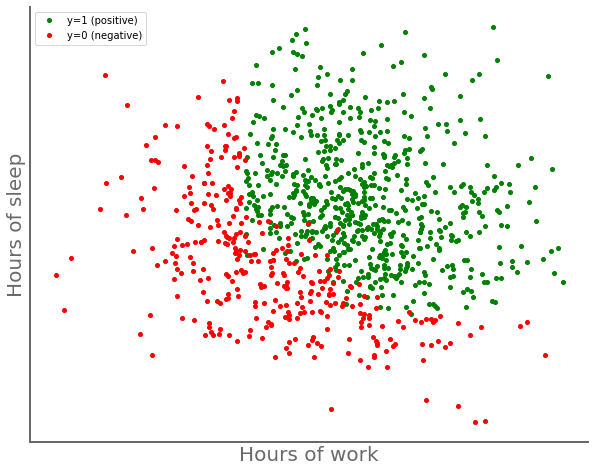

Dataset X        : ndim=2  shape=(1000, 2)   Mean = [5.0401 7.0496]  Std = [1.0111 1.4971]
Dataset y        : ndim=1  shape=(1000,)     Mean = 0.666  Std = 0.47163969298607594


In [5]:
plot_data(x_data, y_data)
vector_infos('Dataset X',x_data)
vector_infos('Dataset y',y_data)

### 2.3 - Preparation of data

We're going to:
- split the data to have : :
  - a training set
  - a test set
- normalize the data

In [6]:
# ---- Split data

n = int(data_size * 0.8)
x_train = x_data[:n]
y_train = y_data[:n]
x_test  = x_data[n:]
y_test  = y_data[n:]

# ---- Normalization

mean = np.mean(x_train, axis=0)
std  = np.std(x_train, axis=0)

x_train = (x_train-mean)/std
x_test  = (x_test-mean)/std

# ---- About it

vector_infos('X_train',x_train)
vector_infos('y_train',y_train)
vector_infos('X_test',x_test)
vector_infos('y_test',y_test)

y_train_h = y_train.reshape(-1,) # nécessaire pour la visu.

X_train          : ndim=2  shape=(800, 2)    Mean = [ 0. -0.]  Std = [1. 1.]
y_train          : ndim=1  shape=(800,)      Mean = 0.6625  Std = 0.47285700798444347
X_test           : ndim=2  shape=(200, 2)    Mean = [ 0.0157 -0.0145]  Std = [0.9671 1.0145]
y_test           : ndim=1  shape=(200,)      Mean = 0.68  Std = 0.46647615158762407


### 2.4 - Have a look

**This is what we know :**

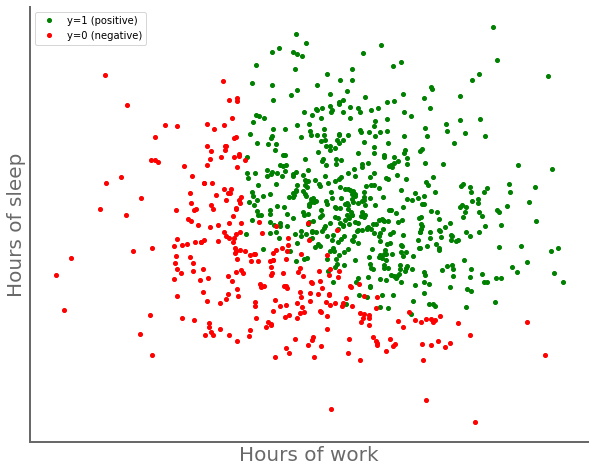

**This is what we want to classify :**

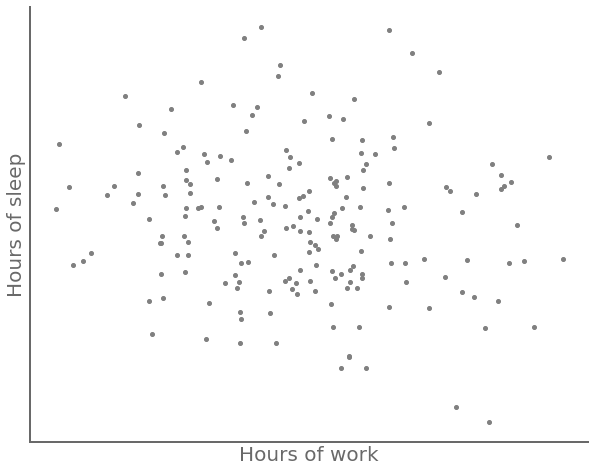

In [7]:
pwk.display_md('**This is what we know :**')
plot_data(x_train, y_train)
pwk.display_md('**This is what we want to classify :**')
plot_data(x_test,  y_test, colors=("gray","gray"), legend=False)

## Step 3 - Logistic model #1
### 3.1 - Here is the classifier

In [8]:
# ---- Create an instance
#      Use SAGA solver (Stochastic Average Gradient descent solver)
#
logreg = LogisticRegression(C=1e5, verbose=1, solver='saga')

# ---- Fit the data.
#
logreg.fit(x_train, y_train)

# ---- Do a prediction
#
y_pred = logreg.predict(x_test)

convergence after 12 epochs took 0 seconds


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished



### 3.3 - Evaluation

Accuracy = Ability to avoid false positives = $\frac{Tp}{Tp+Fp}$  
Recall = Ability to find the right positives = $\frac{Tp}{Tp+Fn}$  
Avec :  
$T_p$ (true positive) Correct positive answer  
$F_p$ (false positive) False positive answer  
$T_n$ (true negative) Correct negative answer  
$F_n$ (false negative) Wrong negative answer  

Accuracy = 0.940    Recall = 0.926


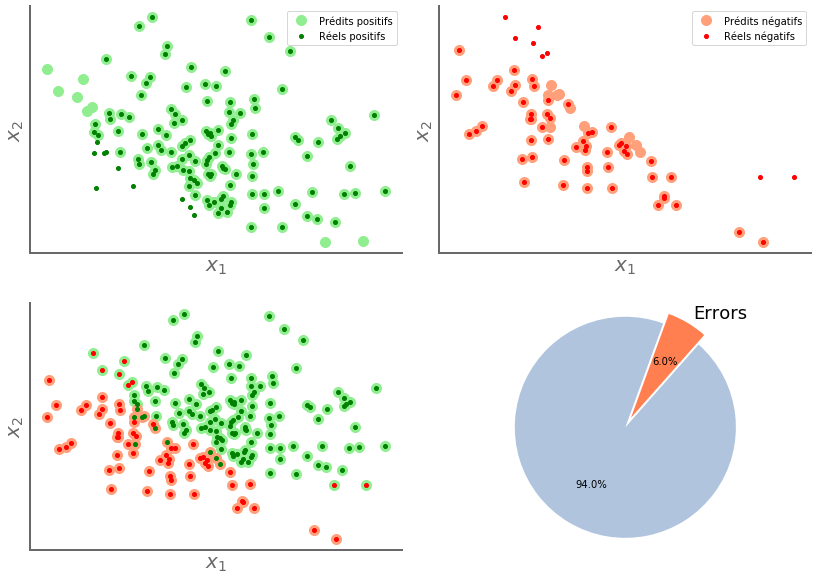

In [9]:
plot_results(x_test,y_test, y_pred)

## Step 4 - Bending the space to a model #2 ;-)

We're going to increase the characteristics of our observations, with : ${x_1}^2$, ${x_2}^2$, ${x_1}^3$ et ${x_2}^3$  

$
X=
\begin{bmatrix}1 & x_{11} & x_{12} \\
\vdots & \dots\\
1 & x_{m1} & x_{m2}  \end{bmatrix}
\text{et }
X_{ng}=\begin{bmatrix}1 & x_{11} & x_{12} & x_{11}^2 & x_{12}^2& x_{11}^3 & x_{12}^3 \\
\vdots & & & \dots \\
1 & x_{m1} & x_{m2} & x_{m1}^2 & x_{m2}^2& x_{m1}^3 & x_{m2}^3 \end{bmatrix}
$

Note : `sklearn.preprocessing.PolynomialFeatures` can do that for us, but we'll do it ourselves:
### 4.1 - Extend data

In [10]:
x_train_enhanced = np.c_[x_train,
                         x_train[:, 0] ** 2,
                         x_train[:, 1] ** 2,
                         x_train[:, 0] ** 3,
                         x_train[:, 1] ** 3]
x_test_enhanced = np.c_[x_test,
                        x_test[:, 0] ** 2,
                        x_test[:, 1] ** 2,
                        x_test[:, 0] ** 3,
                        x_test[:, 1] ** 3]


### 4.2 - Run the classifier
...and with Tensorboard tracking and checkpoint recording.

In [11]:
# ---- Create an instance
#      Use SAGA solver (Stochastic Average Gradient descent solver)
#
logreg = LogisticRegression(C=1e5, verbose=1, solver='saga', max_iter=5000)

# ---- Fit the data.
#
logreg.fit(x_train_enhanced, y_train)

# ---- Do a prediction
#
y_pred = logreg.predict(x_test_enhanced)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 1585 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


### 4.3 - Evaluation

Accuracy = 0.977    Recall = 0.949


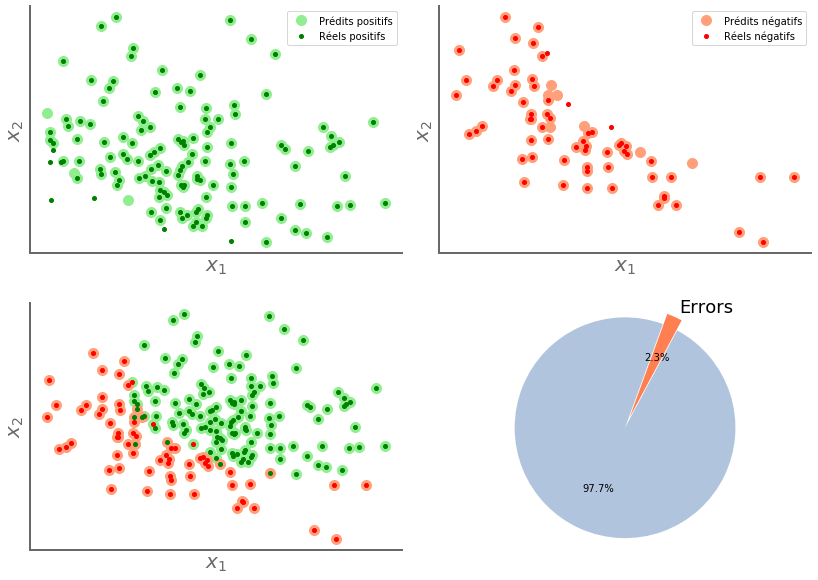

In [12]:
plot_results(x_test_enhanced, y_test, y_pred)

In [13]:
pwk.end()

End time is : Wednesday 27 January 2021, 18:21:36
Duration is : 00:00:03 516ms
This notebook ends here


---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>